In [1]:
import skeliner as sk
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


In [2]:
seg_id = 720575940545220339
MESH_PATH = f"../data/{seg_id}.obj"
mesh = sk.io.load_mesh(MESH_PATH)

In [3]:
skel = sk.skeletonize(mesh, 
    detect_soma=True,     
    # --- post-processing parameters ---
    collapse_soma=True, 
    bridge_gaps=True, 
    prune_tiny_neurites=True, 
    unit = "nm", # mesh unit
    id = seg_id,
    verbose=True,
)

[skeliner] starting skeletonisation (636,684 vertices, 1,274,227 faces)
 ↳  build surface graph                          … 7.60 s
 ↳  bin surface vertices by geodesic distance    … 6.40 s
 ↳  compute bin centroids and radii              … 10.78 s
 ↳  post-skeletonization soma detection          … 0.22 s
      └─ Found soma at [951560.0, 1086484.6, 34101.5]
      └─ (r = 10148.5, 5344.6, 2575.0)
 ↳  map mesh faces to skeleton edges             … 1.10 s
 ↳  merge redundant near-soma nodes              … 0.79 s
      └─ 129 nodes merged into soma
      └─ Moved soma to [951519.2, 1086418.2, 34093.4]
      └─ (r =  9589.7, 6004.5, 2608.4)
 ↳  bridge skeleton gaps                         … 0.34 s
 ↳  build global minimum-spanning tree           … 0.19 s
 ↳  prune tiny neurites                          … 1.16 s
      └─ Merged 8 peri-soma nodes into soma 
      └─ Moved soma to [951589.5, 1086350.8, 34190.9]
      └─ (r =  8795.8, 5831.4, 2727.5)
TOTAL (soma + core + post)                   

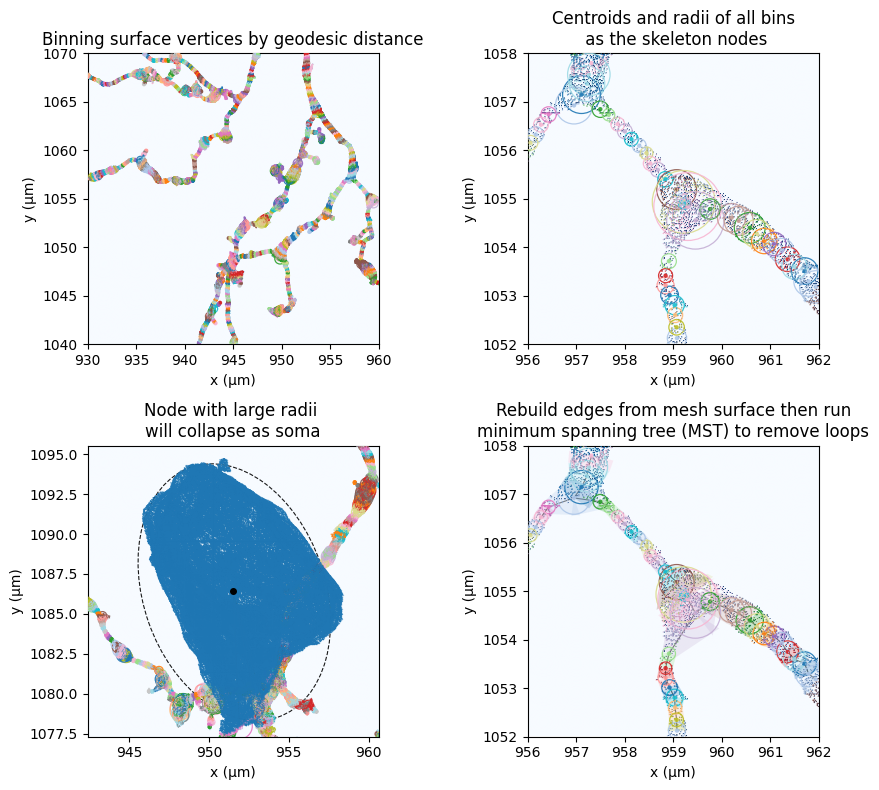

In [4]:
# fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplot_mosaic(
    """
    AB
    CD
    """,
    figsize=(10, 8),
)

_ = sk.plot.details(
    skel, mesh, 
    plane="xy", bins=300,
    draw_nodes=True,
    draw_edges=True, show_node_ids=False,
    xlim=(0.93e3, 0.96e3), 
    ylim=(1.04e3, 1.07e3),
    scale=1e-3, unit="µm",
    ax=ax["A"], title="Binning surface vertices by geodesic distance"
)   


_ = sk.plot.details(
    skel, mesh,
    plane="xy", bins=300,
    draw_nodes=True,
    draw_edges=False, show_node_ids=False,
    xlim=(0.956e3, 0.962e3), 
    ylim=(1.052e3, 1.058e3),
    scale=1e-3, unit="µm",
    ax=ax["B"], title="Centroids and radii of all bins\n as the skeleton nodes"
)

soma_xy = skel.nodes[0][:2] * 1e-3
soma_r = skel.r[0] * 1e-3 * 2
_ = sk.plot.details(
    skel, mesh,
    plane="xy", bins=300,
    draw_nodes=True,
    draw_edges=True, show_node_ids=False,
    xlim=(soma_xy[0] - soma_r, soma_xy[0] + soma_r),
    ylim=(soma_xy[1] - soma_r, soma_xy[1] + soma_r),
    scale=1e-3, unit="µm",
    ax=ax["C"], title="Node with large radii \nwill collapse as soma"
)

_ = sk.plot.details(
    skel, mesh,
    plane="xy", bins=300,
    draw_nodes=True, draw_cylinders=True, 
    draw_edges=True, show_node_ids=False,
    xlim=(0.956e3, 0.962e3), 
    ylim=(1.052e3, 1.058e3),
    scale=1e-3, unit="µm",
    ax=ax["D"], title="Rebuild edges from mesh surface then run\nminimum spanning tree (MST) to remove loops"
)


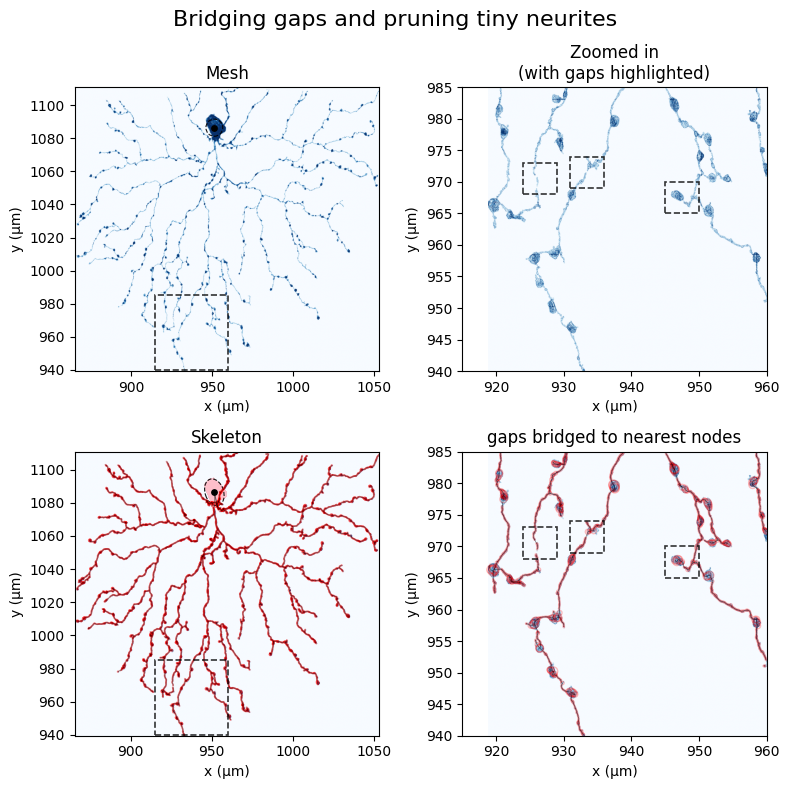

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# whole cell
## mesh
sk.plot2d(
    skel, mesh, plane="xy",
    scale=1e-3, unit="µm",
    draw_skel=False, draw_edges=False, 
    draw_soma_mask=False,
    ax=ax[0, 0]
)
## skeleton on mesh
sk.plot2d(
    skel, mesh, plane="xy",
    scale=1e-3, unit="µm",
    draw_edges=True, draw_soma_mask=True,
    ax=ax[1, 0]
)

# zoomed in
x0, x1 = (915, 960)
y0, y1 = (940, 985)
## mesh
sk.plot2d(
    skel, mesh, plane="xy",
    scale=1e-3, unit="µm",
    xlim=(x0, x1), ylim=(y0, y1),
    draw_skel=False, draw_edges=False,
    ax=ax[0, 1],
)
## skeleton on mesh
sk.plot2d(
    skel, mesh, plane="xy",
    scale=1e-3,  unit="µm",
    xlim=(x0, x1),
    ylim=(y0, y1),
    draw_edges=True,
    ax=ax[1, 1],
)
ax[0, 0].set_title("Mesh")
ax[1, 0].set_title("Skeleton")
ax[0, 1].set_title("Zoomed in\n(with gaps highlighted)")
ax[1, 1].set_title("gaps bridged to nearest nodes")

rect = [Rectangle(
    (x0, y0), x1-x0, y1-y0,
    linewidth=1.2, edgecolor="black", linestyle="--", facecolor="none",
    alpha=0.8, zorder=3,
) for _ in range(2)]
ax[0, 0].add_patch(rect[0])
ax[1, 0].add_patch(rect[1])

# highlight gaps    
gaps_xy = [[(924, 929), (968, 973)], [(931, 936), (969, 974)], [(945, 950), (965, 970)]]
for (x0, x1), (y0, y1) in gaps_xy:
    gap_rect = [Rectangle(
        (x0, y0), x1-x0, y1-y0, linewidth=1.2, edgecolor="black", linestyle="--", facecolor="none",
        alpha=0.8, zorder=3,        
    ) for _ in range(2)]
    ax[0, 1].add_patch(gap_rect[0])
    ax[1, 1].add_patch(gap_rect[1])

for a in ax.flatten():
    a.set_aspect("auto")

fig.suptitle("Bridging gaps and pruning tiny neurites", fontsize=16)
fig.tight_layout()

In [6]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-11-12 17:55:42CET

Python implementation: CPython
Python version       : 3.13.9
IPython version      : 9.7.0

matplotlib: 3.10.7
skeliner  : 0.2.3

Watermark: 2.5.0

